In [24]:
import matplotlib.pyplot as plt
from math import sqrt
from matplotlib import pyplot
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from statsmodels.graphics.tsaplots import plot_acf
from keras import layers
from keras.optimizers import Adam
import keras

import math
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

import yfinance as yf

In [25]:
def step_ahead(y, jump=1):
    y_current = y[:-(jump + 1), 0]
    y_next = y[jump:-1, 0]
    return np.reshape(y_current, (len(y_current), 1)), np.reshape(y_next, (len(y_next), 1))

In [26]:
START_DATE = '2016-01-01'
END_DATE = '2024-5-28'
ASSET = ['AAPL','TSLA', 'MSFT',"NVDA","GOOGL","AMZN","META"]
prices_df = yf.download(ASSET,start = START_DATE,end = END_DATE)
print(f'Downloaded {prices_df.shape[0]} rows of data.')
prices_df.head()

[*********************100%%**********************]  7 of 7 completed

Downloaded 2113 rows of data.


Price       Adj Close                                                         \
Ticker           AAPL       AMZN      GOOGL        META       MSFT      NVDA   
Date                                                                           
2016-01-04  23.914480  31.849501  37.972000  102.111656  48.521473  7.899907   
2016-01-05  23.315199  31.689501  38.076500  102.621124  48.742836  8.026814   
2016-01-06  22.858923  31.632500  37.966499  102.860863  47.857407  7.694904   
2016-01-07  21.894178  30.396999  37.049999   97.816216  46.192806  7.389843   
2016-01-08  22.009949  30.352501  36.545502   97.226845  46.334454  7.231208   

Price                      Close                        ...       Open  \
Ticker           TSLA       AAPL       AMZN      GOOGL  ...       MSFT   
Date                                                    ...              
2016-01-04  14.894000  26.337500  31.849501  37.972000  ...  54.320000   
2016-01-05  14.895333  25.677500  31.689501  38.076500  ...  54.930000   
2016-01-06  14.602667  25.174999  31.632500  37.966499  ...  54.320000   
2016-01-07  14.376667  24.112499  30.396999  37.049999  ...  52.700001   
2016-01-08  14.066667  24.240000  30.352501  36.545502  ...  52.369999   

Price                             Volume                                 \
Ticker        NVDA       TSLA       AAPL       AMZN     GOOGL      META   
Date                                                                      
2016-01-04  8.0725  15.381333  270597600  186290000  67382000  37912400   
2016-01-05  8.2450  15.090667  223164000  116452000  45216000  23258200   
2016-01-06  8.0875  14.666667  273829600  106584000  48206000  25096200   
2016-01-07  7.6850  14.279333  324377600  141498000  63132000  45172900   
2016-01-08  7.6675  14.524000  283192000  110258000  47506000  35402300   

Price                                      
Ticker          MSFT      NVDA       TSLA  
Date                                       
2016-01-04  53778000  35807600  102406500  
2016-01-05  34079700  49027200   47802000  
2016-01-06  39518900  44934400   56686500  
2016-01-07  56564900  64530400   53314500  
2016-01-08  48754000  39847200   54421500  

[5 rows x 42 columns]

In [27]:
big_7_return = prices_df['Close'].dropna()
big_7_return.head()

Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2016-01-04,26.337500,31.849501,37.972000,102.220001,54.799999,8.0925,14.894000
2016-01-05,25.677500,31.689501,38.076500,102.730003,55.049999,8.2225,14.895333
2016-01-06,25.174999,31.632500,37.966499,102.970001,54.049999,7.8825,14.602667
2016-01-07,24.112499,30.396999,37.049999,97.919998,52.169998,7.5700,14.376667
2016-01-08,24.240000,30.352501,36.545502,97.330002,52.330002,7.4075,14.066667


In [28]:
len(big_7_return)

2113

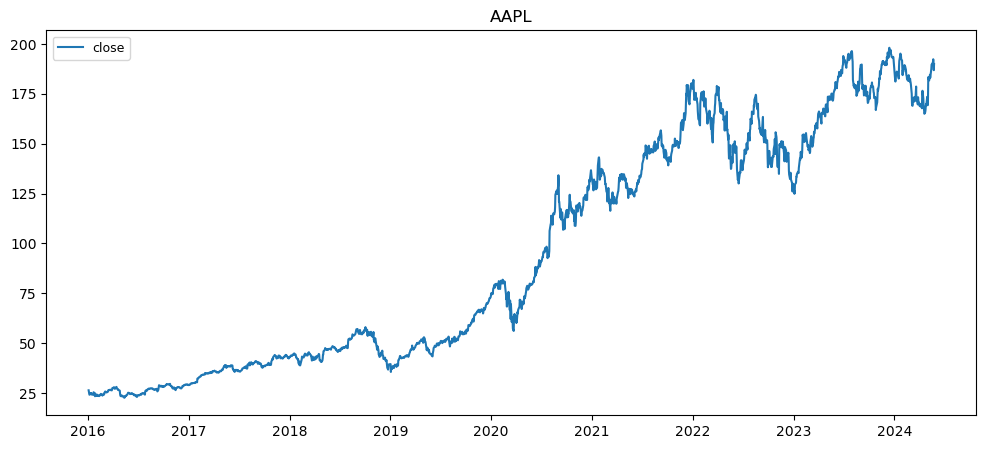

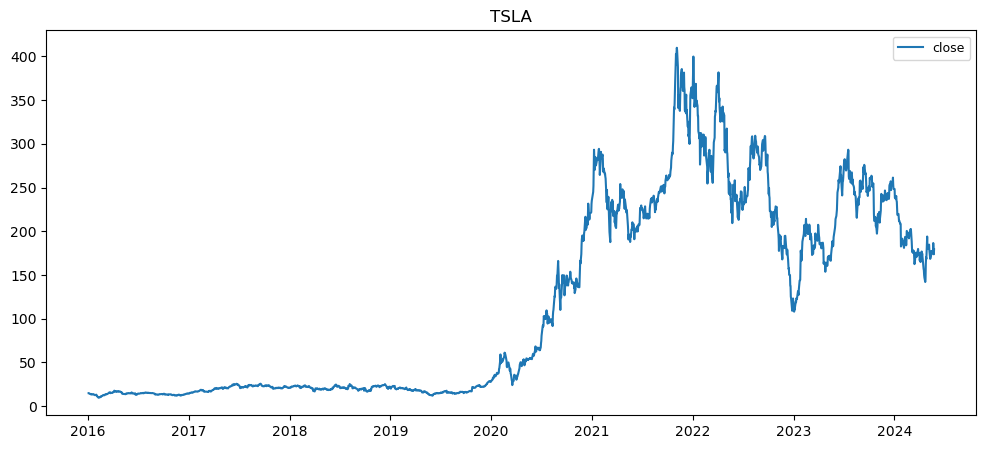

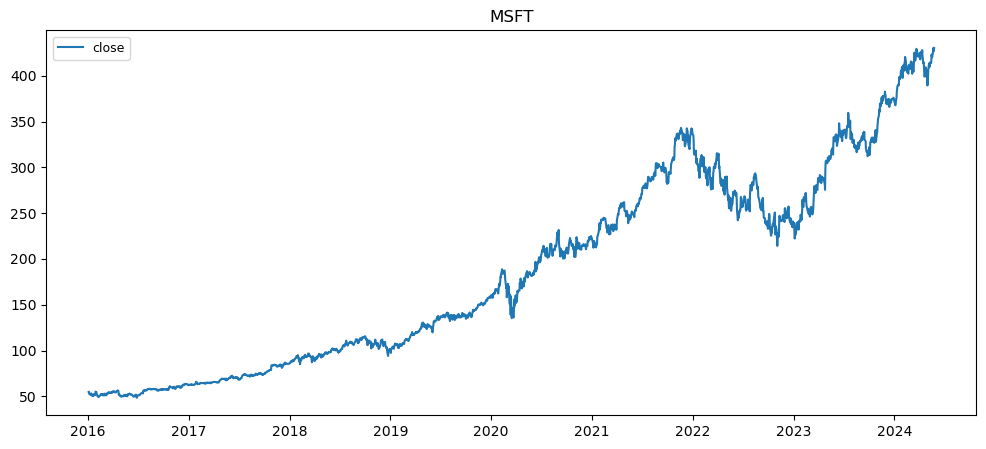

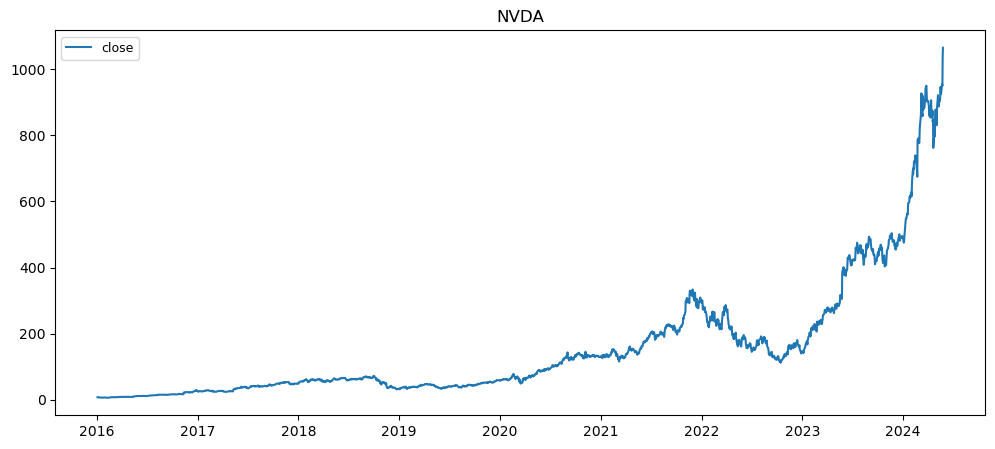

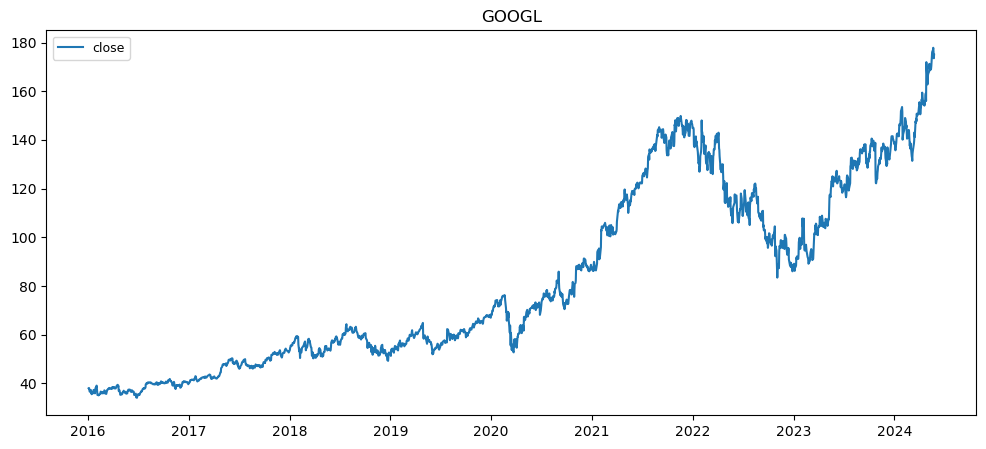

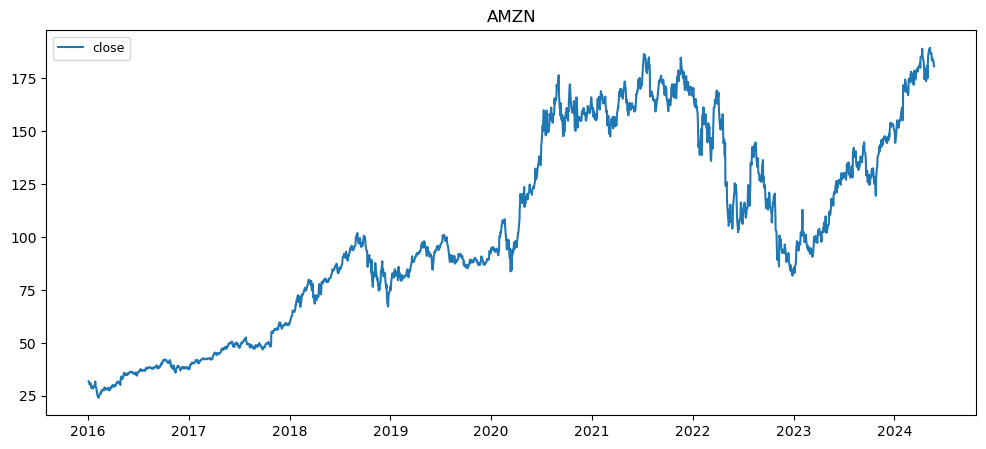

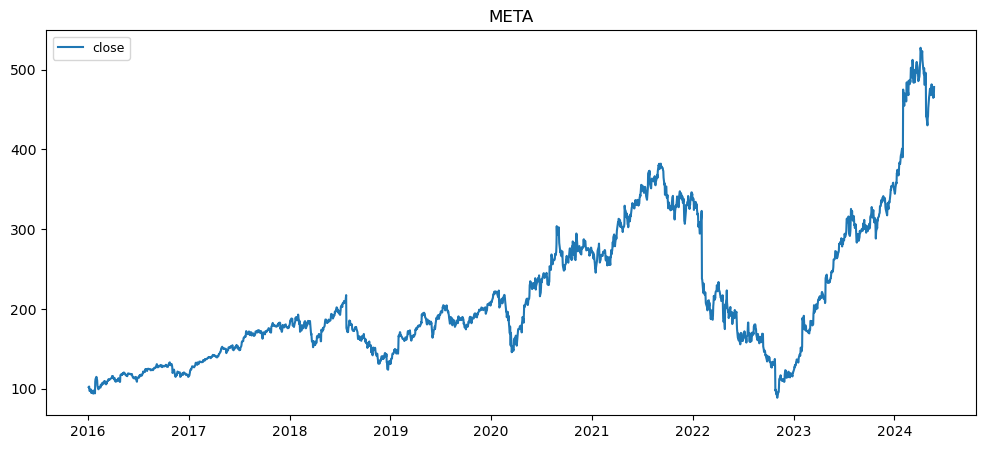

In [29]:
for i in ['AAPL','TSLA', 'MSFT','NVDA','GOOGL','AMZN','META']:
    y=big_7_return[i]
    plt.rcParams['figure.figsize'] = (12,5)
    x=y.index

    plt.plot(x, y, label='close')   
    plt.legend(fontsize=9)
    plt.title(i)
    plt.show()  

In [30]:
df_prediction_RNN = pd.DataFrame(index = y.index)

C:\Users\卢博文\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)             │ (None, 1, 256)              │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1, 1)                │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,305 (259.00 KB)

 Trainable params: 66,305 (259.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1198/1198 - 2s - 1ms/step - loss: 4.8096e-04
Epoch 2/10
1198/1198 - 1s - 674us/step - loss: 1.4756e-04
Epoch 3/10
1198/1198 - 1s - 662us/step - loss: 1.0851e-04
Epoch 4/10
1198/1198 - 1s - 660us/step - loss: 1.0569e-04
Epoch 5/10
1198/1198 - 1s - 659us/step - loss: 1.0104e-04
Epoch 6/10
1198/1198 - 1s - 668us/step - loss: 9.6156e-05
Epoch 7/10
1198/1198 - 1s - 662us/step - loss: 1.1471e-04
Epoch 8/10
1198/1198 - 1s - 664us/step - loss: 9.5564e-05
Epoch 9/10
1198/1198 - 1s - 662us/step - loss: 9.5379e-05
Epoch 10/10
1198/1198 - 1s - 668us/step - loss: 9.3678e-05
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step
Train Score: 1.49 RMSE
Test Score: 3.33 RMSE


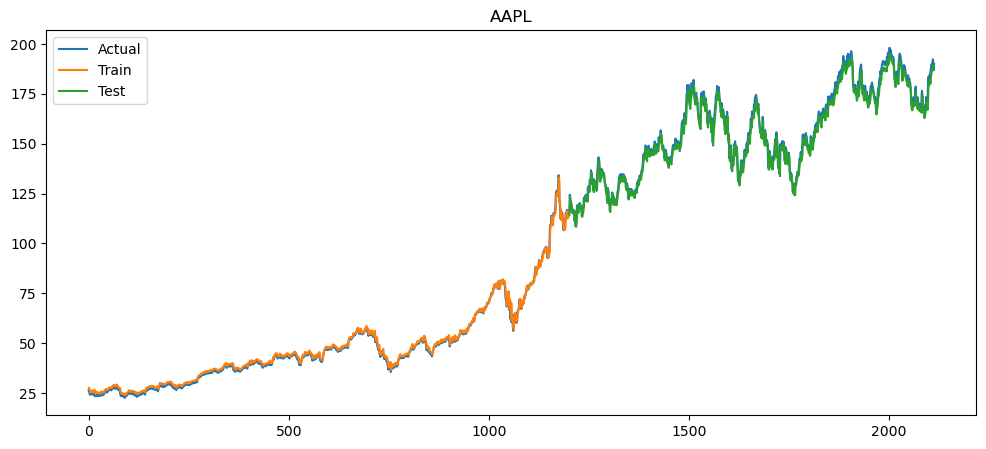

C:\Users\卢博文\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_9 (SimpleRNN)             │ (None, 1, 256)              │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1, 1)                │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,305 (259.00 KB)

 Trainable params: 66,305 (259.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1198/1198 - 2s - 2ms/step - loss: 3.2696e-04
Epoch 2/10
1198/1198 - 1s - 665us/step - loss: 7.4354e-05
Epoch 3/10
1198/1198 - 1s - 660us/step - loss: 9.0485e-05
Epoch 4/10
1198/1198 - 1s - 691us/step - loss: 7.1877e-05
Epoch 5/10
1198/1198 - 1s - 712us/step - loss: 5.8942e-05
Epoch 6/10
1198/1198 - 1s - 671us/step - loss: 5.4464e-05
Epoch 7/10
1198/1198 - 1s - 660us/step - loss: 6.7593e-05
Epoch 8/10
1198/1198 - 1s - 656us/step - loss: 5.0337e-05
Epoch 9/10
1198/1198 - 1s - 663us/step - loss: 5.8844e-05
Epoch 10/10
1198/1198 - 1s - 713us/step - loss: 5.9248e-05
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
Train Score: 2.08 RMSE
Test Score: 9.32 RMSE


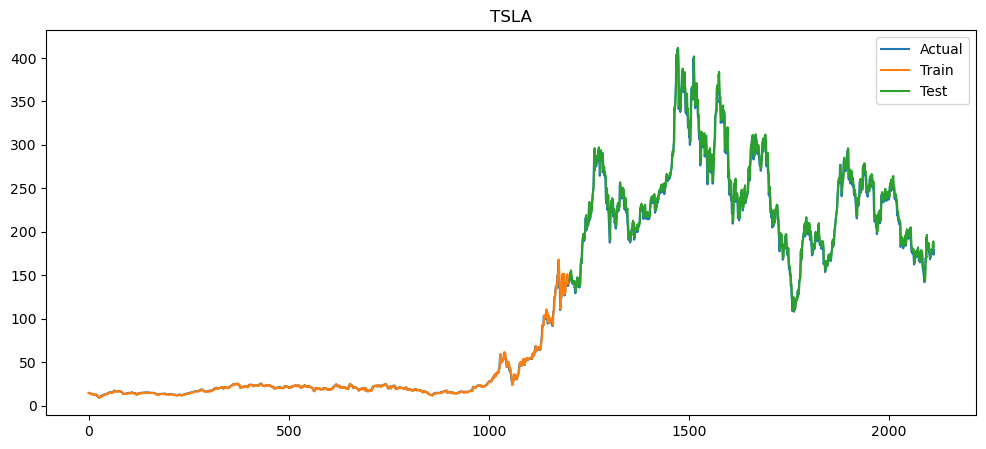

C:\Users\卢博文\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)            │ (None, 1, 256)              │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1, 1)                │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,305 (259.00 KB)

 Trainable params: 66,305 (259.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1198/1198 - 2s - 1ms/step - loss: 8.2015e-04
Epoch 2/10
1198/1198 - 1s - 643us/step - loss: 7.5484e-05
Epoch 3/10
1198/1198 - 1s - 632us/step - loss: 1.0047e-04
Epoch 4/10
1198/1198 - 1s - 661us/step - loss: 9.7900e-05
Epoch 5/10
1198/1198 - 1s - 645us/step - loss: 8.2091e-05
Epoch 6/10
1198/1198 - 1s - 672us/step - loss: 8.2795e-05
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
Train Score: 3.51 RMSE
Test Score: 12.76 RMSE


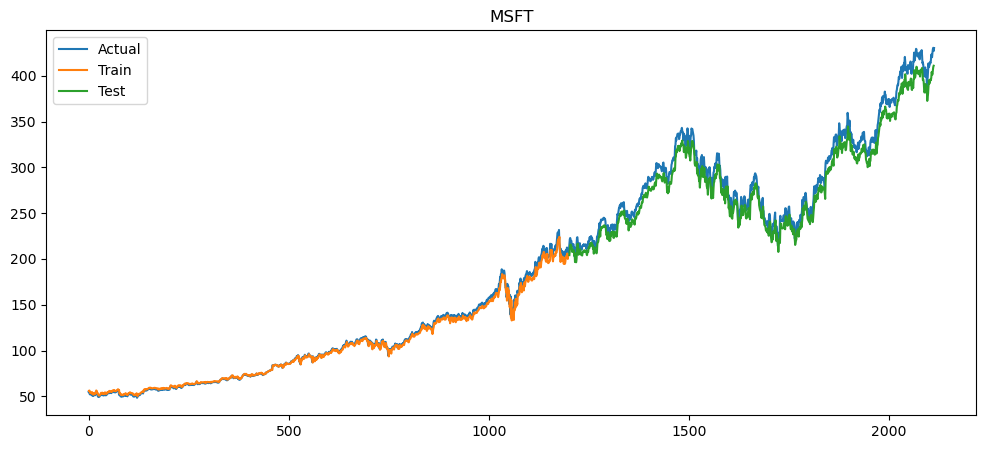

C:\Users\卢博文\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_11 (SimpleRNN)            │ (None, 1, 256)              │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1, 1)                │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,305 (259.00 KB)

 Trainable params: 66,305 (259.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1198/1198 - 2s - 1ms/step - loss: 2.7479e-05
Epoch 2/10
1198/1198 - 1s - 658us/step - loss: 9.8995e-06
Epoch 3/10
1198/1198 - 1s - 681us/step - loss: 8.9743e-06
Epoch 4/10
1198/1198 - 1s - 660us/step - loss: 7.2084e-06
Epoch 5/10
1198/1198 - 1s - 654us/step - loss: 8.3554e-06
Epoch 6/10
1198/1198 - 1s - 663us/step - loss: 6.6989e-06
Epoch 7/10
1198/1198 - 1s - 649us/step - loss: 6.8948e-06
Epoch 8/10
1198/1198 - 1s - 648us/step - loss: 6.6196e-06
Epoch 9/10
1198/1198 - 1s - 689us/step - loss: 5.6540e-06
Epoch 10/10
1198/1198 - 1s - 675us/step - loss: 5.3826e-06
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
Train Score: 1.65 RMSE
Test Score: 13.90 RMSE


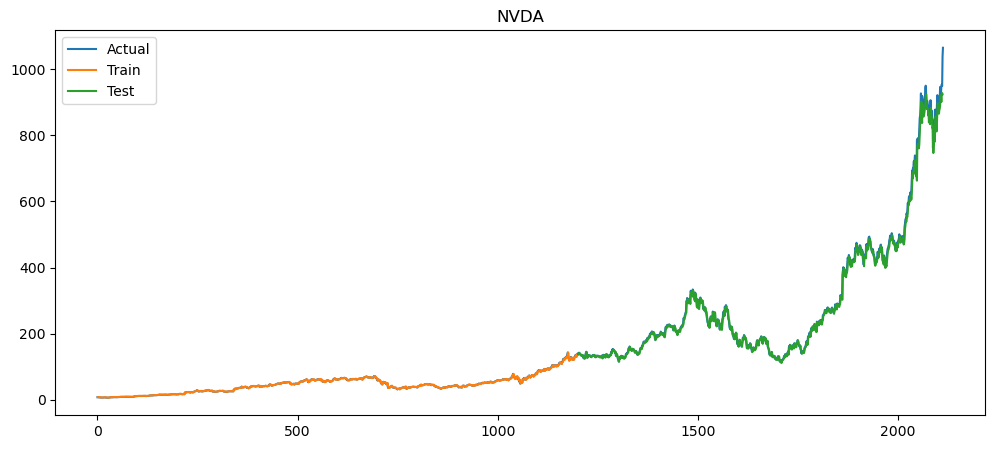

C:\Users\卢博文\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_12 (SimpleRNN)            │ (None, 1, 256)              │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1, 1)                │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,305 (259.00 KB)

 Trainable params: 66,305 (259.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1198/1198 - 2s - 1ms/step - loss: 3.7441e-04
Epoch 2/10
1198/1198 - 1s - 643us/step - loss: 8.0922e-05
Epoch 3/10
1198/1198 - 1s - 645us/step - loss: 8.3639e-05
Epoch 4/10
1198/1198 - 1s - 640us/step - loss: 8.5624e-05
Epoch 5/10
1198/1198 - 1s - 632us/step - loss: 7.7279e-05
Epoch 6/10
1198/1198 - 1s - 680us/step - loss: 7.6723e-05
Epoch 7/10
1198/1198 - 1s - 645us/step - loss: 7.8839e-05
Epoch 8/10
1198/1198 - 1s - 639us/step - loss: 7.3687e-05
Epoch 9/10
1198/1198 - 1s - 649us/step - loss: 6.7966e-05
Epoch 10/10
1198/1198 - 1s - 706us/step - loss: 7.2341e-05
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
Train Score: 1.54 RMSE
Test Score: 2.42 RMSE


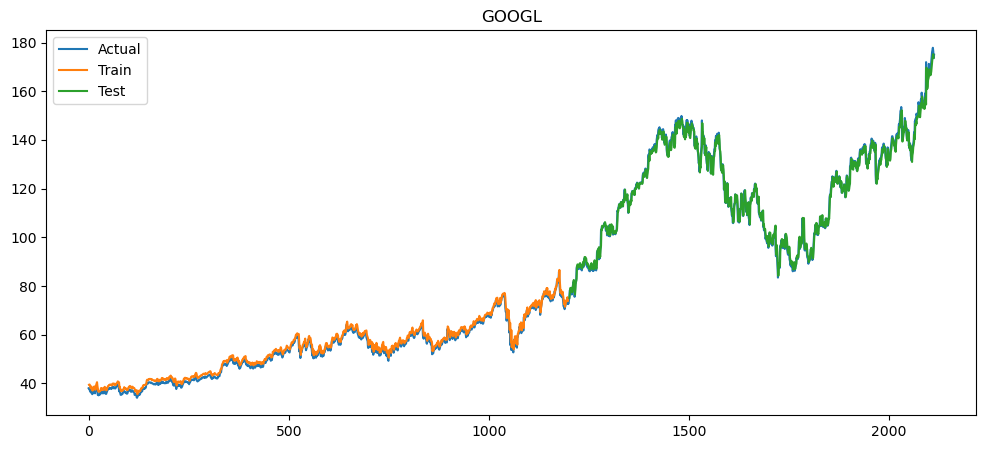

C:\Users\卢博文\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_13 (SimpleRNN)            │ (None, 1, 256)              │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1, 1)                │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,305 (259.00 KB)

 Trainable params: 66,305 (259.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1198/1198 - 2s - 1ms/step - loss: 0.0017
Epoch 2/10
1198/1198 - 1s - 619us/step - loss: 2.2190e-04
Epoch 3/10
1198/1198 - 1s - 629us/step - loss: 2.3149e-04
Epoch 4/10
1198/1198 - 1s - 647us/step - loss: 2.0796e-04
Epoch 5/10
1198/1198 - 1s - 667us/step - loss: 2.3154e-04
Epoch 6/10
1198/1198 - 1s - 622us/step - loss: 2.0550e-04
Epoch 7/10
1198/1198 - 1s - 649us/step - loss: 1.8501e-04
Epoch 8/10
1198/1198 - 1s - 650us/step - loss: 2.0069e-04
Epoch 9/10
1198/1198 - 1s - 621us/step - loss: 1.6713e-04
Epoch 10/10
1198/1198 - 1s - 621us/step - loss: 2.0242e-04
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step
Train Score: 3.74 RMSE
Test Score: 6.17 RMSE


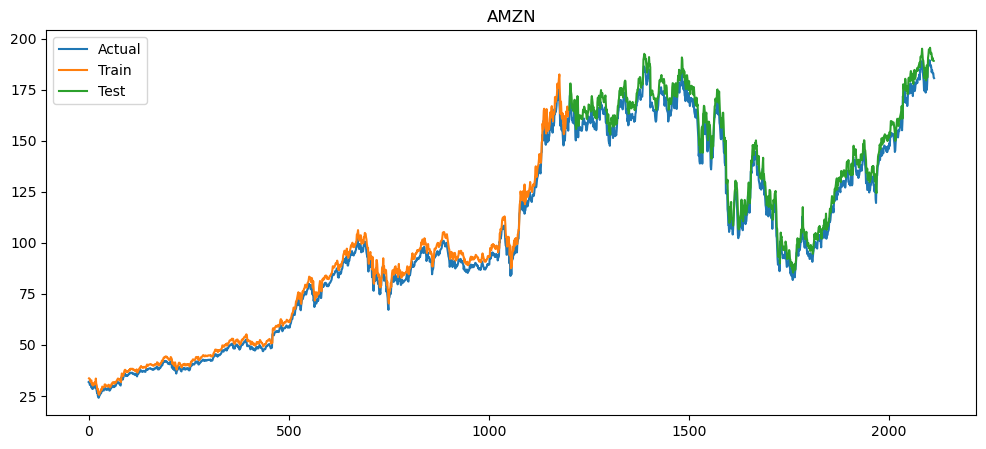

C:\Users\卢博文\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_14 (SimpleRNN)            │ (None, 1, 256)              │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1, 1)                │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,305 (259.00 KB)

 Trainable params: 66,305 (259.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1198/1198 - 2s - 2ms/step - loss: 9.0745e-04
Epoch 2/10
1198/1198 - 1s - 657us/step - loss: 1.2467e-04
Epoch 3/10
1198/1198 - 1s - 693us/step - loss: 1.2635e-04
Epoch 4/10
1198/1198 - 1s - 656us/step - loss: 1.2257e-04
Epoch 5/10
1198/1198 - 1s - 647us/step - loss: 1.1844e-04
Epoch 6/10
1198/1198 - 1s - 656us/step - loss: 1.2211e-04
Epoch 7/10
1198/1198 - 1s - 650us/step - loss: 1.3028e-04
Epoch 8/10
1198/1198 - 1s - 657us/step - loss: 1.0289e-04
Epoch 9/10
1198/1198 - 1s - 651us/step - loss: 1.1221e-04
Epoch 10/10
1198/1198 - 1s - 671us/step - loss: 1.1154e-04
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
Train Score: 3.67 RMSE
Test Score: 7.66 RMSE


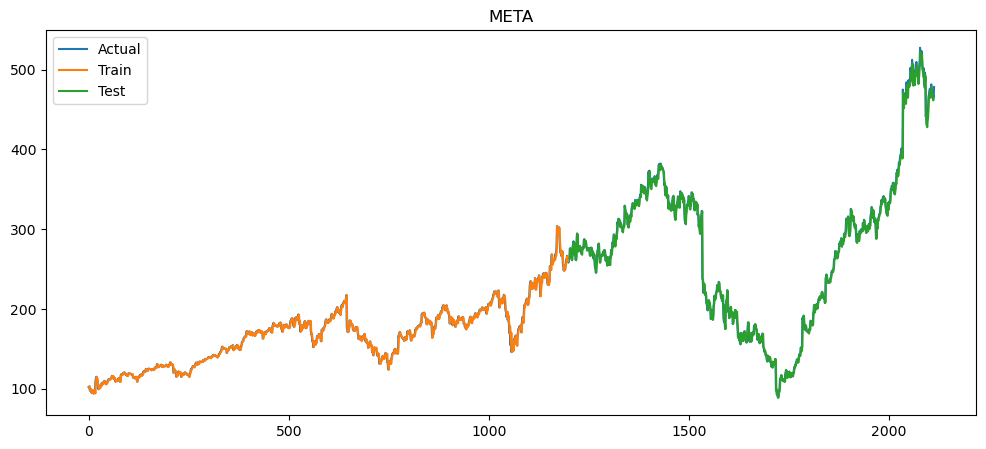

In [31]:
for i in ['AAPL','TSLA', 'MSFT','NVDA','GOOGL','AMZN','META']:
    y=big_7_return[i]
    Tp = 1200
    look_back = 1
    values = y.values
    
    mm = MinMaxScaler()
    values=np.reshape(values,(values.shape[0],1))
    values=mm.fit_transform(values)
    train, test = values[0:Tp], values[Tp:]
    
    trainXb, trainYb = step_ahead(train, look_back)
    testXb, testYb = step_ahead(test, look_back)
    trainX = np.reshape(trainXb, (trainXb.shape[0], 1, trainXb.shape[1]))
    testX = np.reshape(testXb, (testXb.shape[0], 1, testXb.shape[1]))
    
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(units=256, return_sequences=True, input_shape=(1,look_back)),
    
        keras.layers.Dense(1)
    ])
    
    model.summary()
    
    and_i_stop = EarlyStopping(monitor = 'loss', patience = 4, mode = 'auto')
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainYb, epochs=10, callbacks = [and_i_stop], batch_size=1, verbose=2)
    
    #make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    #invert predictions
    trainPredict = np.reshape(trainPredict, (trainPredict.shape[0], 1))
    testPredict = np.reshape(testPredict, (testPredict.shape[0], 1))
    trainPredict = mm.inverse_transform(trainPredict)
    trainY = mm.inverse_transform(trainYb)
    testPredict = mm.inverse_transform(testPredict)
    testY = mm.inverse_transform(testYb)
    #calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))
    
    #shift train predictions for plotting
    trainPredictPlot = np.empty_like(values)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    #shift test predictions for plotting
    testPredictPlot = np.empty_like(values)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(values)-1, :] = testPredict
    #plot baseline and predictions
    plt.plot(mm.inverse_transform(values),label="Actual")
    plt.plot(trainPredictPlot,label="Train")
    plt.plot(testPredictPlot,label="Test")
    plt.title(i) 
    plt.legend()
    plt.show()
    df_prediction_RNN['Observed_'+i]=y
    df_prediction_RNN['Train_Prediction_'+i]=trainPredictPlot
    df_prediction_RNN['Test_Prediction_'+i]=testPredictPlot

In [32]:
df_prediction_RNN.head()

,Observed_AAPL,Train_Prediction_AAPL,Test_Prediction_AAPL,Observed_TSLA,Train_Prediction_TSLA,Test_Prediction_TSLA,Observed_MSFT,Train_Prediction_MSFT,Test_Prediction_MSFT,Observed_NVDA,...,Test_Prediction_NVDA,Observed_GOOGL,Train_Prediction_GOOGL,Test_Prediction_GOOGL,Observed_AMZN,Train_Prediction_AMZN,Test_Prediction_AMZN,Observed_META,Train_Prediction_META,Test_Prediction_META
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,26.337500,NaN,NaN,14.894000,NaN,NaN,54.799999,NaN,NaN,8.0925,...,NaN,37.972000,NaN,NaN,31.849501,NaN,NaN,102.220001,NaN,NaN
2016-01-05,25.677500,27.559221,NaN,14.895333,14.636160,NaN,55.049999,56.110271,NaN,8.2225,...,NaN,38.076500,39.410786,NaN,31.689501,33.622036,NaN,102.730003,102.050751,NaN
2016-01-06,25.174999,26.910831,NaN,14.602667,14.637517,NaN,54.049999,56.348263,NaN,7.8825,...,NaN,37.966499,39.513931,NaN,31.632500,33.455868,NaN,102.970001,102.561111,NaN
2016-01-07,24.112499,26.417170,NaN,14.376667,14.339531,NaN,52.169998,55.396301,NaN,7.5700,...,NaN,37.049999,39.405350,NaN,30.396999,33.396671,NaN,97.919998,102.801285,NaN
2016-01-08,24.240000,25.373354,NaN,14.066667,14.109425,NaN,52.330002,53.606613,NaN,7.4075,...,NaN,36.545502,38.500687,NaN,30.352501,32.113525,NaN,97.330002,97.747650,NaN


In [33]:
#df_prediction_RNN.to_csv('RNN.csv',index = True)

In [34]:
big_7_return.head()

Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2016-01-04,26.337500,31.849501,37.972000,102.220001,54.799999,8.0925,14.894000
2016-01-05,25.677500,31.689501,38.076500,102.730003,55.049999,8.2225,14.895333
2016-01-06,25.174999,31.632500,37.966499,102.970001,54.049999,7.8825,14.602667
2016-01-07,24.112499,30.396999,37.049999,97.919998,52.169998,7.5700,14.376667
2016-01-08,24.240000,30.352501,36.545502,97.330002,52.330002,7.4075,14.066667


In [35]:
df_prediction_LSTM = pd.DataFrame(index = y.index)

C:\Users\卢博文\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                       │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1198/1198 - 2s - 2ms/step - loss: 0.0021
Epoch 2/10
1198/1198 - 1s - 980us/step - loss: 7.8784e-05
Epoch 3/10
1198/1198 - 1s - 968us/step - loss: 9.4165e-05
Epoch 4/10
1198/1198 - 1s - 979us/step - loss: 8.2568e-05
Epoch 5/10
1198/1198 - 1s - 955us/step - loss: 9.1716e-05
Epoch 6/10
1198/1198 - 1s - 986us/step - loss: 8.8464e-05
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
Train Score: 1.65 RMSE
Test Score: 5.54 RMSE


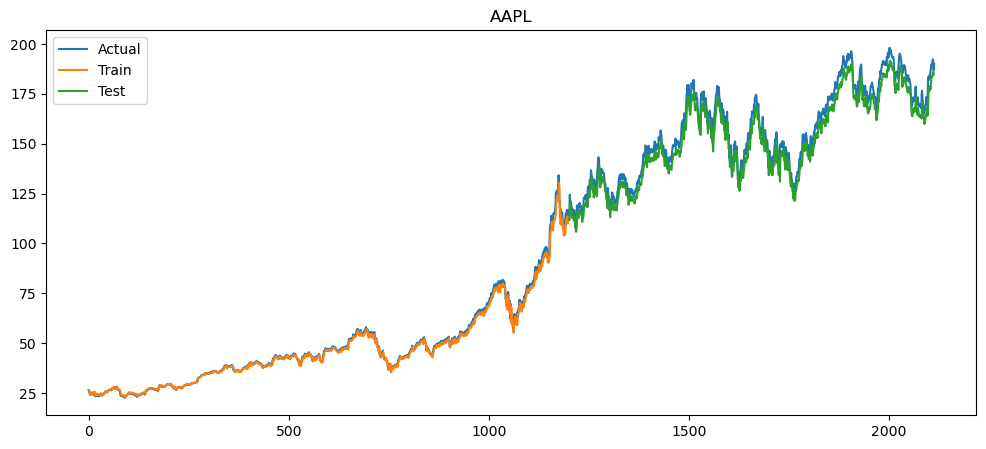

C:\Users\卢博文\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                       │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1198/1198 - 2s - 2ms/step - loss: 7.7237e-04
Epoch 2/10
1198/1198 - 1s - 977us/step - loss: 5.3747e-05
Epoch 3/10
1198/1198 - 1s - 993us/step - loss: 6.2343e-05
Epoch 4/10
1198/1198 - 1s - 979us/step - loss: 6.2269e-05
Epoch 5/10
1198/1198 - 1s - 959us/step - loss: 5.6471e-05
Epoch 6/10
1198/1198 - 1s - 985us/step - loss: 5.6154e-05
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
Train Score: 2.13 RMSE
Test Score: 9.35 RMSE


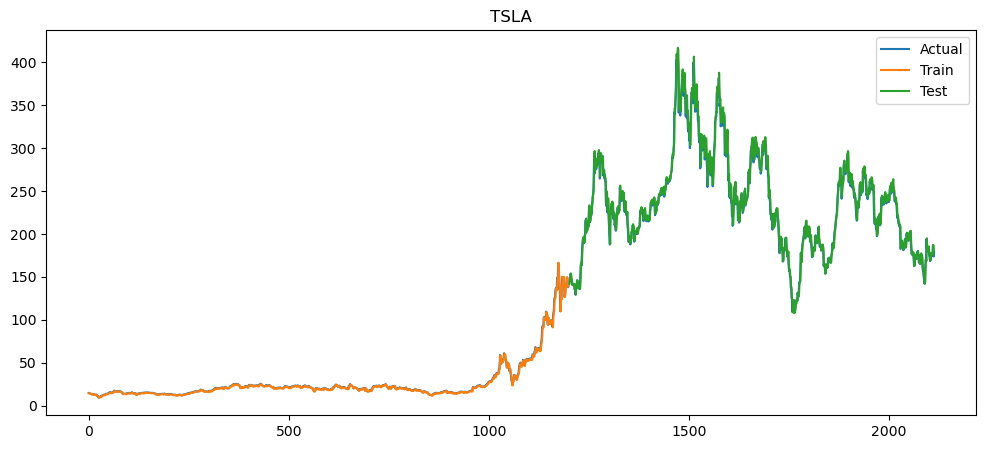

C:\Users\卢博文\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                       │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1198/1198 - 2s - 2ms/step - loss: 0.0015
Epoch 2/10
1198/1198 - 1s - 977us/step - loss: 6.4197e-05
Epoch 3/10
1198/1198 - 1s - 1ms/step - loss: 7.1382e-05
Epoch 4/10
1198/1198 - 1s - 1ms/step - loss: 6.5642e-05
Epoch 5/10
1198/1198 - 1s - 1ms/step - loss: 8.0132e-05
Epoch 6/10
1198/1198 - 1s - 991us/step - loss: 7.1533e-05
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
Train Score: 3.44 RMSE
Test Score: 7.71 RMSE


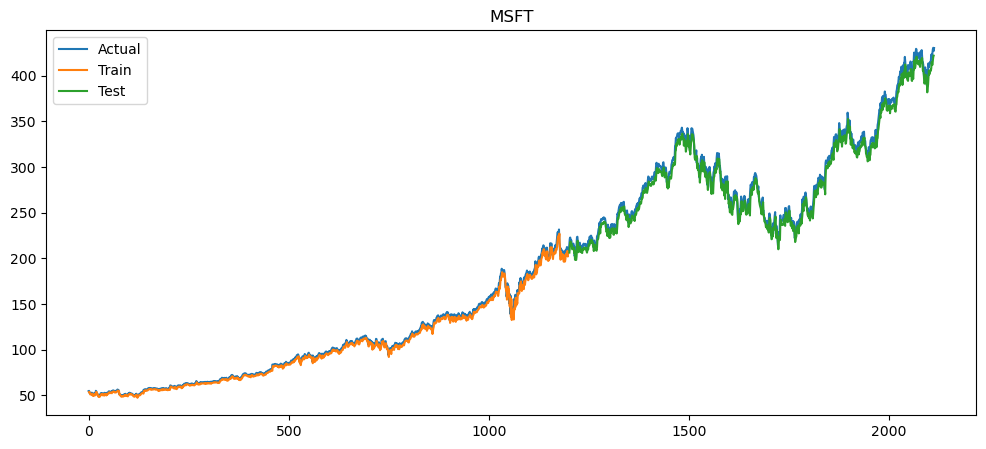

C:\Users\卢博文\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1198/1198 - 2s - 2ms/step - loss: 1.4295e-04
Epoch 2/10
1198/1198 - 1s - 955us/step - loss: 5.4995e-06
Epoch 3/10
1198/1198 - 1s - 983us/step - loss: 6.1735e-06
Epoch 4/10
1198/1198 - 1s - 1ms/step - loss: 7.0356e-06
Epoch 5/10
1198/1198 - 1s - 1ms/step - loss: 6.3377e-06
Epoch 6/10
1198/1198 - 1s - 971us/step - loss: 5.0867e-06
Epoch 7/10
1198/1198 - 1s - 918us/step - loss: 6.0846e-06
Epoch 8/10
1198/1198 - 1s - 930us/step - loss: 5.5549e-06
Epoch 9/10
1198/1198 - 1s - 992us/step - loss: 6.3002e-06
Epoch 10/10
1198/1198 - 1s - 968us/step - loss: 5.3324e-06
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
Train Score: 1.67 RMSE
Test Score: 18.65 RMSE


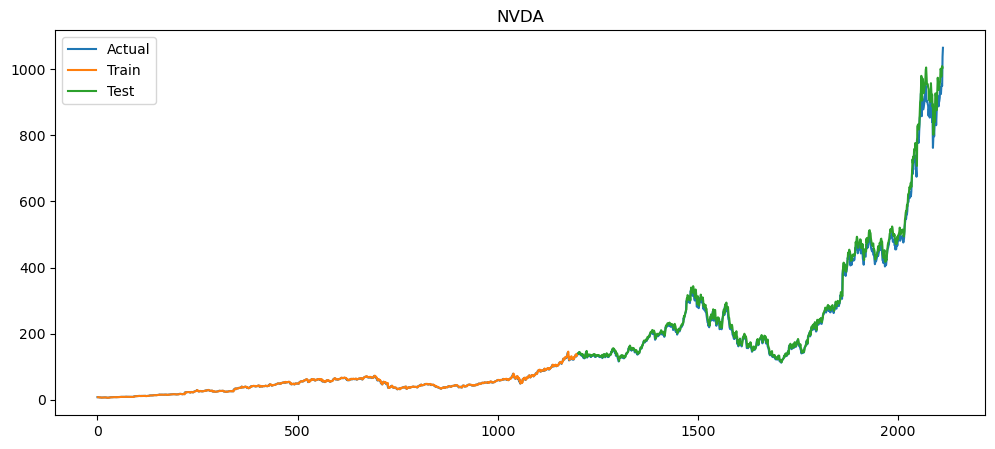

C:\Users\卢博文\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                       │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1198/1198 - 3s - 2ms/step - loss: 8.4522e-04
Epoch 2/10
1198/1198 - 1s - 937us/step - loss: 6.3051e-05
Epoch 3/10
1198/1198 - 1s - 940us/step - loss: 6.8572e-05
Epoch 4/10
1198/1198 - 1s - 939us/step - loss: 7.6765e-05
Epoch 5/10
1198/1198 - 1s - 929us/step - loss: 6.8697e-05
Epoch 6/10
1198/1198 - 1s - 932us/step - loss: 6.8018e-05
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
Train Score: 1.11 RMSE
Test Score: 2.76 RMSE


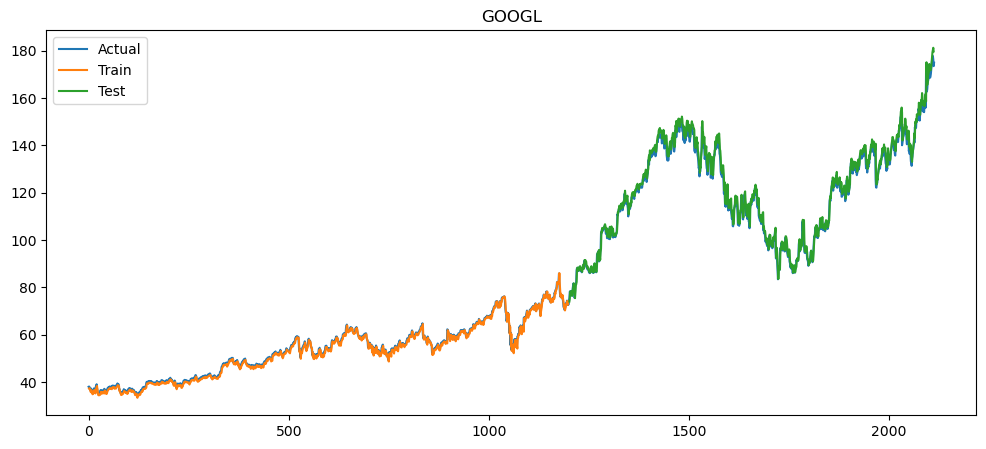

C:\Users\卢博文\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                       │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1198/1198 - 2s - 2ms/step - loss: 0.0052
Epoch 2/10
1198/1198 - 1s - 1ms/step - loss: 1.5221e-04
Epoch 3/10
1198/1198 - 1s - 963us/step - loss: 1.7523e-04
Epoch 4/10
1198/1198 - 1s - 966us/step - loss: 1.7571e-04
Epoch 5/10
1198/1198 - 1s - 967us/step - loss: 1.9372e-04
Epoch 6/10
1198/1198 - 1s - 941us/step - loss: 1.7525e-04
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
Train Score: 2.25 RMSE
Test Score: 4.44 RMSE


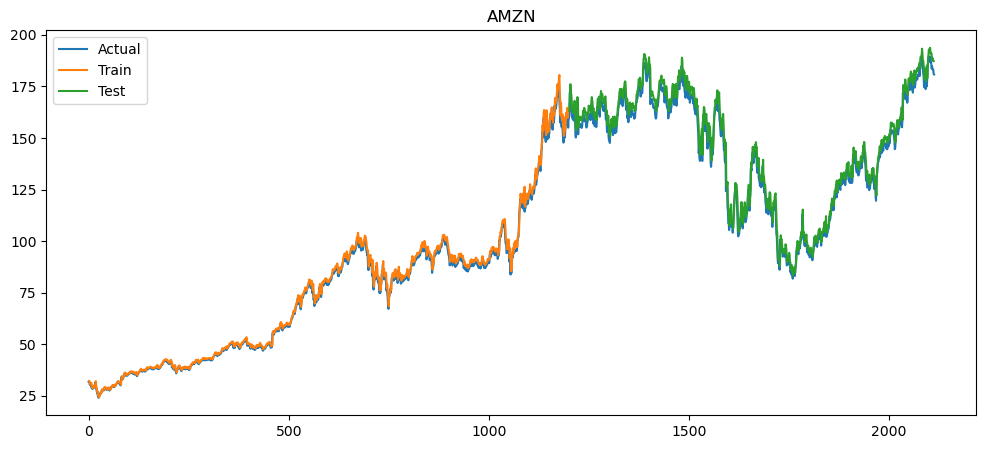

C:\Users\卢博文\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                       │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1198/1198 - 2s - 2ms/step - loss: 0.0015
Epoch 2/10
1198/1198 - 1s - 913us/step - loss: 9.8058e-05
Epoch 3/10
1198/1198 - 1s - 911us/step - loss: 1.1005e-04
Epoch 4/10
1198/1198 - 1s - 926us/step - loss: 1.2106e-04
Epoch 5/10
1198/1198 - 1s - 921us/step - loss: 1.1064e-04
Epoch 6/10
1198/1198 - 1s - 910us/step - loss: 1.0517e-04
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
Train Score: 5.10 RMSE
Test Score: 8.21 RMSE


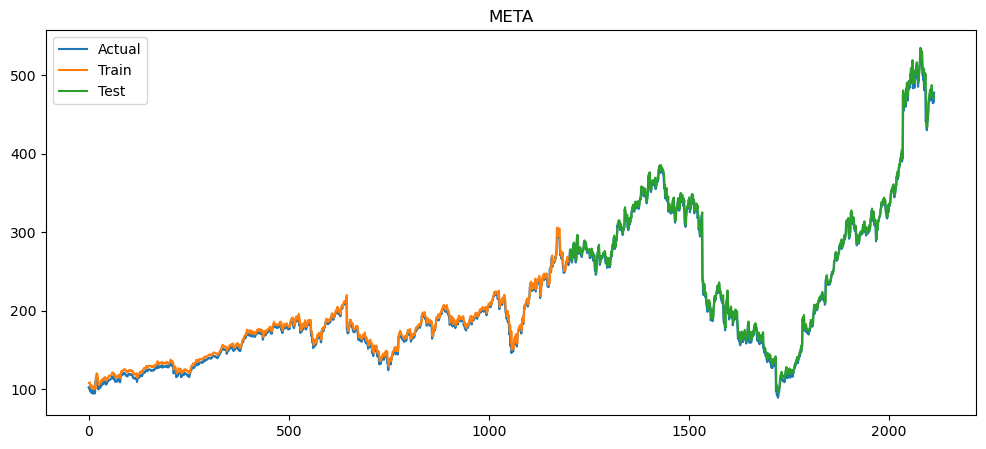

In [36]:
for i in ['AAPL','TSLA', 'MSFT','NVDA','GOOGL','AMZN','META']:
    y=big_7_return[i]
    Tp = 1200
    look_back = 1
    values = y.values

    mm = MinMaxScaler()
    values=np.reshape(values,(values.shape[0],1))
    values=mm.fit_transform(values)
    train, test = values[0:Tp], values[Tp:]
    
    trainXb, trainYb = step_ahead(train, look_back)
    testXb, testYb = step_ahead(test, look_back)
    trainX = np.reshape(trainXb, (trainXb.shape[0], 1, trainXb.shape[1]))
    testX = np.reshape(testXb, (testXb.shape[0], 1, testXb.shape[1]))
    #create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(256, input_shape=(1, look_back)))
    
    model.add(Dense(1))
    model.summary()
    
    and_i_stop = EarlyStopping(monitor = 'loss', patience = 4, mode = 'auto')
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainYb, epochs=10, callbacks = [and_i_stop], batch_size=1, verbose=2)
    #make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    #invert predictions
    trainPredict = mm.inverse_transform(trainPredict)
    trainY = mm.inverse_transform(trainYb)
    testPredict = mm.inverse_transform(testPredict)
    testY = mm.inverse_transform(testYb)
    #calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))
    #shift train predictions for plotting
    trainPredictPlot = np.empty_like(values)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    #shift test predictions for plotting
    testPredictPlot = np.empty_like(values)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(values)-1, :] = testPredict
    #plot baseline and predictions
    plt.plot(mm.inverse_transform(values),label="Actual")
    plt.plot(trainPredictPlot,label="Train")
    plt.plot(testPredictPlot,label="Test")
    plt.title(i) 
    plt.legend()
    plt.show()
    df_prediction_LSTM['Observed_'+i]=y
    df_prediction_LSTM['Train_Prediction_'+i]=trainPredictPlot
    df_prediction_LSTM['Test_Prediction_'+i]=testPredictPlot

In [37]:
df_prediction_LSTM.head()

,Observed_AAPL,Train_Prediction_AAPL,Test_Prediction_AAPL,Observed_TSLA,Train_Prediction_TSLA,Test_Prediction_TSLA,Observed_MSFT,Train_Prediction_MSFT,Test_Prediction_MSFT,Observed_NVDA,...,Test_Prediction_NVDA,Observed_GOOGL,Train_Prediction_GOOGL,Test_Prediction_GOOGL,Observed_AMZN,Train_Prediction_AMZN,Test_Prediction_AMZN,Observed_META,Train_Prediction_META,Test_Prediction_META
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,26.337500,NaN,NaN,14.894000,NaN,NaN,54.799999,NaN,NaN,8.0925,...,NaN,37.972000,NaN,NaN,31.849501,NaN,NaN,102.220001,NaN,NaN
2016-01-05,25.677500,26.576792,NaN,14.895333,14.524461,NaN,55.049999,53.700256,NaN,8.2225,...,NaN,38.076500,37.265568,NaN,31.689501,32.222988,NaN,102.730003,107.799858,NaN
2016-01-06,25.174999,25.945137,NaN,14.602667,14.525784,NaN,54.049999,53.944088,NaN,7.8825,...,NaN,37.966499,37.370853,NaN,31.632500,32.059628,NaN,102.970001,108.288246,NaN
2016-01-07,24.112499,25.464266,NaN,14.376667,14.235477,NaN,52.169998,52.968788,NaN,7.5700,...,NaN,37.049999,37.260029,NaN,30.396999,32.001431,NaN,97.919998,108.518105,NaN
2016-01-08,24.240000,24.447634,NaN,14.066667,14.011312,NaN,52.330002,51.135471,NaN,7.4075,...,NaN,36.545502,36.336922,NaN,30.352501,30.740120,NaN,97.330002,103.685005,NaN


In [38]:
#df_prediction_LSTM.to_csv('LSTM.csv',index = True)